In [1]:
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets
#!~/new_python_3_11_env/bin/python3 -m pip install tensorflow

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import keras
import numpy as np

2025-01-15 10:18:11.094350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 10:18:11.202917: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 10:18:12.038201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-15 10:18:12.038266

In [3]:
# Load original model
original_model = tf.keras.models.load_model('CNNModel/BaseCNN.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights


2025-01-15 10:18:17.343014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13598 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2025-01-15 10:18:17.345435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13598 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [4]:
# @ layers with 2 deconvolution layers
def build_atn(input_shape):
    model = tf.keras.Sequential([
        # First convolutional layers to capture features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Downsample (14, 14, 64)

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample (7, 7, 128)

        # Fully connected layer to integrate features
        layers.Flatten(),  # Flatten to shape (7 * 7 * 128 = 6272)
        layers.Dense(6272, activation='relu'),  # Match the reshape target

        # Deconvolution layers to reconstruct adversarial examples
        layers.Reshape((7, 7, 128)),  # Reshape for deconvolution
        layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),  # (14, 14, 128)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),  # (28, 28, 64)
        
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),  # Output layer (28, 28, 1)
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model

# Build the ATN
input_shape = (28, 28, 1)  # MNIST dataset shape
atn = build_atn(input_shape)


In [5]:
# Define ATN 2 Layers only convulution
'''
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)
'''

"\ndef build_atn(input_shape):\n    model = tf.keras.Sequential([\n        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),\n        layers.MaxPooling2D((2, 2)),\n        layers.Conv2D(64, (3, 3), activation='relu'),\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]\n        layers.Reshape(input_shape),\n        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]\n    ])\n    return model\n\n\ninput_shape = (28, 28, 1)  # Assuming MNIST dataset\natn = build_atn(input_shape)\n"

In [6]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [7]:
# Combine the models
input_img = tf.keras.Input(shape=input_shape)
x_prime = atn(input_img)
y_pred = original_model(x_prime)

combined_model = tf.keras.Model(inputs=input_img, outputs=[x_prime, y_pred])


In [8]:
def get_second_highest_target(y_pred_original):
    # Sort predictions to find the highest and second-highest indices
    top_2_indices = tf.argsort(y_pred_original, direction='DESCENDING', axis=1)[:, :2]
    second_highest_indices = top_2_indices[:, 1]

    # Create one-hot encoding for the second-highest class
    y_target = tf.one_hot(second_highest_indices, depth=y_pred_original.shape[1])
    return y_target


In [9]:
class RandomApply(tf.keras.layers.Layer):
    def __init__(self, layer, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.p = p

    def call(self, x, training=None):
        if not training:
            return x
        return tf.cond(
            tf.random.uniform(()) < self.p,
            lambda: self.layer(x, training=training),
            lambda: x
        )

# A simple pipeline: horizontal flip, random rotation
data_augmentation = tf.keras.Sequential([
    RandomApply(layers.RandomRotation(0.1), p=0.5),
    RandomApply(layers.RandomZoom(0.1,fill_mode='nearest'), p=0.5),
])
augmentation_with_p = RandomApply(data_augmentation, p=0.7)


In [10]:
# Define training procedure

boundaries = [2000,6000,12000]  # Steps at which learning rate changes
values = [1,0.1,0.01, 0.001]  # Corresponding learning rates

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
beta = 0.001  # Weight for input-space loss

@tf.function
def train_step(x, y_original):
    with tf.GradientTape() as tape:
        # Generate adversarial examples
        x_prime = atn(x)
        l_x = input_loss(x, x_prime)
        x_primeT = augmentation_with_p(x_prime, training=True)
        # Get predictions for original and adversarial inputs
        y_pred_original = original_model(x, training=False)
        y_pred = original_model(x_primeT, training=False)

        # Compute the second-highest target dynamically
        y_target = get_second_highest_target(y_pred_original)

        # Compute input loss and output loss separately
        
        l_y = output_loss(y_pred, y_target)

        # Compute the combined loss
        loss = beta * l_x + l_y

    # Compute and apply gradients
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))

    # Return total loss, input loss, and output loss
    return loss, l_x, l_y




In [11]:
# Load MNIST datasetatn
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
#def create_adversarial_target(label):
#    # Example: Shift each label by 1 (cyclic mapping)
#    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Do NOT normalize the images; keep them in the range [0, 255]
    image = tf.cast(image, tf.float32)  # Ensure float32 for compatibility with loss functions
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Return only the raw image and the original label
    return image, label_one_hot

# Apply preprocessing to the dataset
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch and prefetch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded without normalization.")


Dataset loaded without normalization.


In [12]:
from tqdm import tqdm
import time

# Training loop
epochs = 120
batch_size = 32

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

print(f"{'Epoch':<8}{'Total Loss':<12}{'Scaled Input Loss':<12}{'Output Loss':<12}{'Time (s)':<10}")
print("-" * 50)

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    epoch_input_loss = 0
    epoch_output_loss = 0
    batch_count = 0

    # Add progress bar for batches
    for x_batch, y_original_batch in tqdm(mnist_train_atn, desc=f"Epoch {epoch + 1}/{epochs}"):
        loss, l_x, l_y = train_step(x_batch, y_original_batch)  # Get all losses
        epoch_loss += loss.numpy()
        epoch_input_loss += l_x.numpy()*beta
        epoch_output_loss += l_y.numpy()
        batch_count += 1

    # Compute average losses for the epoch
    avg_loss = epoch_loss / batch_count
    avg_input_loss = epoch_input_loss / batch_count
    avg_output_loss = epoch_output_loss / batch_count
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"{epoch + 1:<8}{avg_loss:<12.4f}{avg_input_loss:<12.4f}{avg_output_loss:<12.4f}{elapsed_time:<10.2f}")


Epoch   Total Loss  Scaled Input LossOutput Loss Time (s)  
--------------------------------------------------


Epoch 1/120:   0%|          | 0/1875 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2025-01-15 10:18:23.814899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
Epoch 1/120: 100%|██████████| 1875/1875 [02:22<00:00, 13.15it/s]


1       3.7598      2.0216      1.7382      142.61    


Epoch 2/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.78it/s]


2       2.6760      1.1921      1.4839      136.03    


Epoch 3/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.86it/s]


3       2.4348      1.0632      1.3715      135.33    


Epoch 4/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.00it/s]


4       2.2898      0.9993      1.2905      133.95    


Epoch 5/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.90it/s]


5       2.1566      0.9512      1.2054      134.86    


Epoch 6/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.84it/s]


6       2.0647      0.9204      1.1442      135.51    


Epoch 7/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.90it/s]


7       1.9890      0.8969      1.0922      134.94    


Epoch 8/120: 100%|██████████| 1875/1875 [02:21<00:00, 13.23it/s]


8       1.9450      0.8819      1.0631      141.69    


Epoch 9/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.97it/s]


9       1.8520      0.8616      0.9905      134.25    


Epoch 10/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.95it/s]


10      1.7963      0.8517      0.9445      134.40    


Epoch 11/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.86it/s]


11      1.7372      0.8339      0.9033      135.31    


Epoch 12/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.59it/s]


12      1.6910      0.8278      0.8632      137.93    


Epoch 13/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.82it/s]


13      1.6492      0.8212      0.8280      135.71    


Epoch 14/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.69it/s]


14      1.6140      0.8164      0.7976      136.99    


Epoch 15/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.09it/s]


15      1.5473      0.8044      0.7429      133.06    


Epoch 16/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.60it/s]


16      1.5270      0.7985      0.7284      137.89    


Epoch 17/120: 100%|██████████| 1875/1875 [02:24<00:00, 13.01it/s]


17      1.5082      0.7925      0.7157      144.12    


Epoch 18/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.92it/s]


18      1.4464      0.7825      0.6639      134.72    


Epoch 19/120: 100%|██████████| 1875/1875 [02:26<00:00, 12.84it/s]


19      1.4494      0.7814      0.6680      146.08    


Epoch 20/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.85it/s]


20      1.4168      0.7764      0.6404      135.40    


Epoch 21/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.65it/s]


21      1.3868      0.7710      0.6158      137.38    


Epoch 22/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.87it/s]


22      1.3610      0.7656      0.5954      135.16    


Epoch 23/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.72it/s]


23      1.3400      0.7653      0.5747      136.66    


Epoch 24/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.55it/s]


24      1.3385      0.7633      0.5752      138.36    


Epoch 25/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.55it/s]


25      1.3144      0.7558      0.5586      138.42    


Epoch 26/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.88it/s]


26      1.2954      0.7502      0.5452      135.10    


Epoch 27/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.12it/s]


27      1.2666      0.7479      0.5188      132.83    


Epoch 28/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.50it/s]


28      1.2650      0.7434      0.5216      138.85    


Epoch 29/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.76it/s]


29      1.2314      0.7366      0.4948      136.25    


Epoch 30/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.85it/s]


30      1.2223      0.7366      0.4857      135.34    


Epoch 31/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.94it/s]


31      1.2024      0.7320      0.4704      134.47    


Epoch 32/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.04it/s]


32      1.2086      0.7360      0.4726      133.58    


Epoch 33/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.15it/s]


33      1.1892      0.7307      0.4585      132.47    


Epoch 34/120: 100%|██████████| 1875/1875 [02:20<00:00, 13.32it/s]


34      1.1830      0.7242      0.4588      140.81    


Epoch 35/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.91it/s]


35      1.1640      0.7191      0.4449      134.79    


Epoch 36/120: 100%|██████████| 1875/1875 [02:20<00:00, 13.31it/s]


36      1.1730      0.7214      0.4516      140.84    


Epoch 37/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.62it/s]


37      1.1419      0.7145      0.4275      137.68    


Epoch 38/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.01it/s]


38      1.1280      0.7100      0.4180      133.79    


Epoch 39/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.70it/s]


39      1.1269      0.7095      0.4175      136.87    


Epoch 40/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.76it/s]


40      1.1138      0.7040      0.4098      136.23    


Epoch 41/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.89it/s]


41      1.0991      0.7006      0.3985      134.97    


Epoch 42/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.21it/s]


42      1.0947      0.7009      0.3938      131.95    


Epoch 43/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.68it/s]


43      1.0948      0.6981      0.3967      137.09    


Epoch 44/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.12it/s]


44      1.0741      0.6924      0.3817      132.78    


Epoch 45/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.82it/s]


45      1.0790      0.6924      0.3866      135.63    


Epoch 46/120: 100%|██████████| 1875/1875 [02:08<00:00, 14.54it/s]


46      1.0481      0.6834      0.3647      128.92    


Epoch 47/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.07it/s]


47      1.0607      0.6867      0.3740      133.27    


Epoch 48/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.55it/s]


48      1.0639      0.6861      0.3778      138.37    


Epoch 49/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.68it/s]


49      1.0555      0.6853      0.3702      137.10    


Epoch 50/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.19it/s]


50      1.0267      0.6763      0.3504      132.11    


Epoch 51/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.90it/s]


51      1.0504      0.6800      0.3704      134.91    


Epoch 52/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.72it/s]


52      1.0403      0.6788      0.3614      136.71    


Epoch 53/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.15it/s]


53      1.0198      0.6737      0.3461      132.48    


Epoch 54/120: 100%|██████████| 1875/1875 [02:09<00:00, 14.44it/s]


54      1.0016      0.6657      0.3359      129.85    


Epoch 55/120: 100%|██████████| 1875/1875 [02:10<00:00, 14.35it/s]


55      0.9979      0.6646      0.3333      130.70    


Epoch 56/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.22it/s]


56      1.0099      0.6710      0.3389      131.90    


Epoch 57/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.96it/s]


57      1.0047      0.6645      0.3402      134.35    


Epoch 58/120: 100%|██████████| 1875/1875 [02:21<00:00, 13.23it/s]


58      1.0155      0.6685      0.3470      141.75    


Epoch 59/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.64it/s]


59      1.0068      0.6677      0.3391      137.45    


Epoch 60/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.63it/s]


60      0.9947      0.6644      0.3303      137.60    


Epoch 61/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.91it/s]


61      0.9868      0.6616      0.3252      134.77    


Epoch 62/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.92it/s]


62      0.9807      0.6570      0.3238      134.67    


Epoch 63/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.52it/s]


63      0.9827      0.6583      0.3244      138.65    


Epoch 64/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.62it/s]


64      0.9826      0.6569      0.3258      137.68    


Epoch 65/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.73it/s]


65      0.9807      0.6586      0.3221      136.60    


Epoch 66/120: 100%|██████████| 1875/1875 [02:21<00:00, 13.26it/s]


66      0.9943      0.6619      0.3324      141.42    


Epoch 67/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.28it/s]


67      0.9440      0.6459      0.2981      131.33    


Epoch 68/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.49it/s]


68      0.9771      0.6556      0.3215      138.96    


Epoch 69/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.89it/s]


69      0.9614      0.6501      0.3113      135.00    


Epoch 70/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.63it/s]


70      0.9605      0.6502      0.3103      137.55    


Epoch 71/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.08it/s]


71      0.9484      0.6465      0.3020      133.13    


Epoch 72/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.12it/s]


72      0.9425      0.6427      0.2998      132.75    


Epoch 73/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.62it/s]


73      0.9496      0.6428      0.3068      137.71    


Epoch 74/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.16it/s]


74      0.9404      0.6419      0.2985      132.44    


Epoch 75/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.16it/s]


75      0.9306      0.6361      0.2945      132.47    


Epoch 76/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.03it/s]


76      0.9281      0.6356      0.2924      133.61    


Epoch 77/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.25it/s]


77      0.9176      0.6330      0.2847      131.54    


Epoch 78/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.76it/s]


78      0.9399      0.6406      0.2993      136.32    


Epoch 79/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.96it/s]


79      0.9376      0.6392      0.2984      134.32    


Epoch 80/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.89it/s]


80      0.9244      0.6349      0.2895      134.95    


Epoch 81/120: 100%|██████████| 1875/1875 [02:10<00:00, 14.32it/s]


81      0.9065      0.6281      0.2785      130.95    


Epoch 82/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.82it/s]


82      0.9291      0.6342      0.2949      135.70    


Epoch 83/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.58it/s]


83      0.9262      0.6348      0.2914      138.13    


Epoch 84/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.25it/s]


84      0.9039      0.6257      0.2782      131.60    


Epoch 85/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.77it/s]


85      0.9165      0.6288      0.2877      136.21    


Epoch 86/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.06it/s]


86      0.8998      0.6262      0.2736      133.37    


Epoch 87/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.17it/s]


87      0.9044      0.6276      0.2768      132.29    


Epoch 88/120: 100%|██████████| 1875/1875 [02:10<00:00, 14.36it/s]


88      0.8920      0.6224      0.2696      130.60    


Epoch 89/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.54it/s]


89      0.9166      0.6279      0.2887      138.45    


Epoch 90/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.03it/s]


90      0.9049      0.6263      0.2786      133.67    


Epoch 91/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.50it/s]


91      0.9051      0.6242      0.2809      138.92    


Epoch 92/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.04it/s]


92      0.8844      0.6176      0.2668      133.52    


Epoch 93/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.93it/s]


93      0.8961      0.6217      0.2744      134.58    


Epoch 94/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.58it/s]


94      0.8980      0.6231      0.2749      138.09    


Epoch 95/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.73it/s]


95      0.8846      0.6183      0.2663      136.58    


Epoch 96/120: 100%|██████████| 1875/1875 [02:07<00:00, 14.75it/s]


96      0.8625      0.6130      0.2495      127.10    


Epoch 97/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.07it/s]


97      0.8792      0.6152      0.2640      133.28    


Epoch 98/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.76it/s]


98      0.8890      0.6192      0.2698      136.22    


Epoch 99/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.83it/s]


99      0.8855      0.6175      0.2680      135.60    


Epoch 100/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.74it/s]


100     0.8672      0.6116      0.2556      136.43    


Epoch 101/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.86it/s]


101     0.8749      0.6137      0.2613      135.27    


Epoch 102/120: 100%|██████████| 1875/1875 [02:13<00:00, 13.99it/s]


102     0.8676      0.6101      0.2574      134.00    


Epoch 103/120: 100%|██████████| 1875/1875 [02:19<00:00, 13.45it/s]


103     0.8772      0.6104      0.2668      139.40    


Epoch 104/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.88it/s]


104     0.8671      0.6079      0.2592      135.13    


Epoch 105/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.85it/s]


105     0.8764      0.6115      0.2649      135.43    


Epoch 106/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.82it/s]


106     0.8691      0.6093      0.2598      135.70    


Epoch 107/120: 100%|██████████| 1875/1875 [02:16<00:00, 13.69it/s]


107     0.8754      0.6108      0.2646      136.95    


Epoch 108/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.93it/s]


108     0.8652      0.6069      0.2583      134.62    


Epoch 109/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.04it/s]


109     0.8597      0.6052      0.2545      133.58    


Epoch 110/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.16it/s]


110     0.8559      0.6054      0.2504      132.42    


Epoch 111/120: 100%|██████████| 1875/1875 [02:17<00:00, 13.63it/s]


111     0.8694      0.6091      0.2603      137.60    


Epoch 112/120: 100%|██████████| 1875/1875 [02:18<00:00, 13.53it/s]


112     0.8676      0.6085      0.2591      138.58    


Epoch 113/120: 100%|██████████| 1875/1875 [02:13<00:00, 14.02it/s]


113     0.8503      0.6040      0.2463      133.71    


Epoch 114/120: 100%|██████████| 1875/1875 [02:14<00:00, 13.95it/s]


114     0.8537      0.6024      0.2513      134.44    


Epoch 115/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.88it/s]


115     0.8445      0.5989      0.2456      135.08    


Epoch 116/120: 100%|██████████| 1875/1875 [02:12<00:00, 14.12it/s]


116     0.8382      0.5949      0.2433      132.80    


Epoch 117/120: 100%|██████████| 1875/1875 [02:15<00:00, 13.86it/s]


117     0.8495      0.5969      0.2526      135.28    


Epoch 118/120: 100%|██████████| 1875/1875 [02:19<00:00, 13.46it/s]


118     0.8528      0.6006      0.2522      139.34    


Epoch 119/120: 100%|██████████| 1875/1875 [02:20<00:00, 13.39it/s]


119     0.8478      0.6007      0.2471      140.04    


Epoch 120/120: 100%|██████████| 1875/1875 [02:11<00:00, 14.26it/s]

120     0.8408      0.5960      0.2448      131.51    


# VERIFICATION

In [13]:
# Save the ATN in the newer `.keras` format for future compatibility

# Define model naming function
def generate_model_name(base_name, beta, epochs, structure):
    # Format the model name with hyperparameters
    return f"{base_name}_beta-{beta}_epochs-{epochs}_{structure}.keras"

# Specify model details
#base_name = "adversarial_transformation_network"

#structure = "conv2d_transpose"  # Example structure (descriptive)

# Generate the model name
#model_name = generate_model_name(base_name, beta, epochs, structure)
model_name='ATN_model/ATNInputDiversity07_atn2.keras'
# Save the ATN with the generated name
atn.save(model_name)
print(f"ATN saved successfully as {model_name}")



ATN saved successfully as ATN_model/ATNInputDiversity07_atn2.keras


In [14]:
# Load Model


#loaded_atn_model = tf.keras.models.load_model('ATN_model/ATNPure.keras')

2025-01-15 14:49:24.511458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 0s 33ms/step
True Labels: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Original Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Transformed Predictions: [7 8 7 2 9 0 7 5 5 8 5 2 9 4 2 1 6 3 9 2 5 5 5 6 8 5 5 1 8 7 9 5]
1/1 [==============================] - 0s 33ms/step


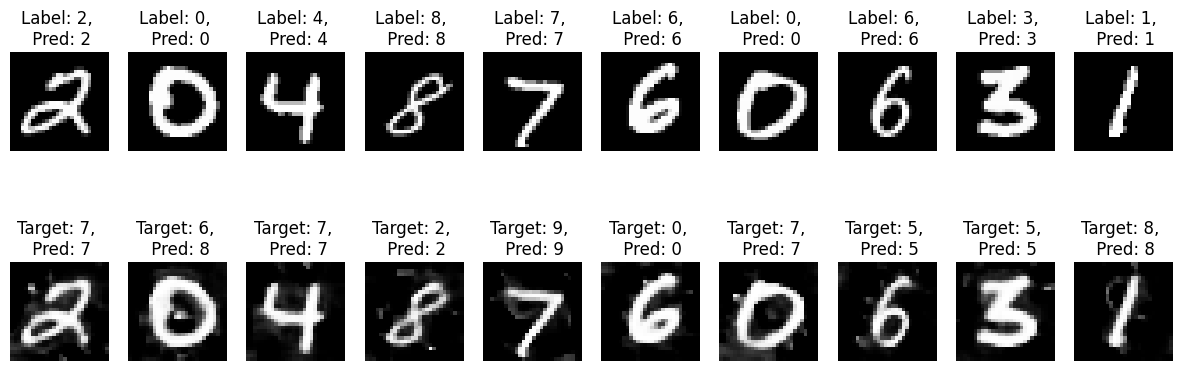

In [15]:

import matplotlib.pyplot as plt







# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch in dataset.take(1):  # Take one batch (two elements per batch in the dataset)
        # Generate transformed images
        x_transformed = atn.predict(x_batch)

        # Get predictions for the original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)

        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)

        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())

        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed, original_model.predict(x_batch))
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed, original_pred):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')

        # Transformed image
        second_highest_target = get_second_highest_target(original_pred[i: i + 1])[0]  # Compute target dynamically
        second_highest_class = tf.argmax(second_highest_target).numpy()

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Target: {second_highest_class}, \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')

    plt.show()


# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [16]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0

    for x_batch, y_original_batch in dataset:  # Only unpack two elements
        if atn:
            # Transform images using ATN
            x_batch = atn.predict(x_batch, verbose=0)  # Suppress verbose output
        # Get predictions from the model
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)
        y_true = tf.argmax(y_original_batch, axis=1)  # True labels
        # Count correct predictions
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]  # Batch size
    
    return correct / total  # Calculate accuracy


# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")


Accuracy on original images: 0.9870
Accuracy on transformed images: 0.0725
